## Импорт требуемых библиотек

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import pprint

PATH_TO_PREDICT_IMG = '../runs/detect/predict/'
PATH_TO_IMG_FOR_PREDICT = '../validation_data/'
PATH_TO_MODEL = ('../runs/detect/train/weights/best.pt')

## Загрузка обученой модели и предсказание

In [2]:
# Загружаем в модель обученные веса
model = YOLO(PATH_TO_MODEL)

# Делаем предсказание всех изображений в папке
results = model.predict(PATH_TO_IMG_FOR_PREDICT,
                        save_dir=PATH_TO_PREDICT_IMG,
                        save=False,
                        conf=0.5)


image 1/3 /home/nikolai/PycharmProjects/pythonProject/src/notebooks/../validation_data/1.png: 448x640 1 left, 38.3ms
image 2/3 /home/nikolai/PycharmProjects/pythonProject/src/notebooks/../validation_data/2.png: 448x640 1 right, 30.5ms
image 3/3 /home/nikolai/PycharmProjects/pythonProject/src/notebooks/../validation_data/3.png: 416x640 (no detections), 31.4ms
Speed: 1.5ms preprocess, 33.4ms inference, 191.8ms postprocess per image at shape (1, 3, 416, 640)


## Постпроцесинг

[{'img': '1.png', 'left_or_right': 'left', 'x_center': 249, 'y_center': 74},
 {'img': '2.png', 'left_or_right': 'right', 'x_center': 669, 'y_center': 226},
 {'img': '3.png',
  'left_or_right': 'not detected',
  'x_center': None,
  'y_center': None}]


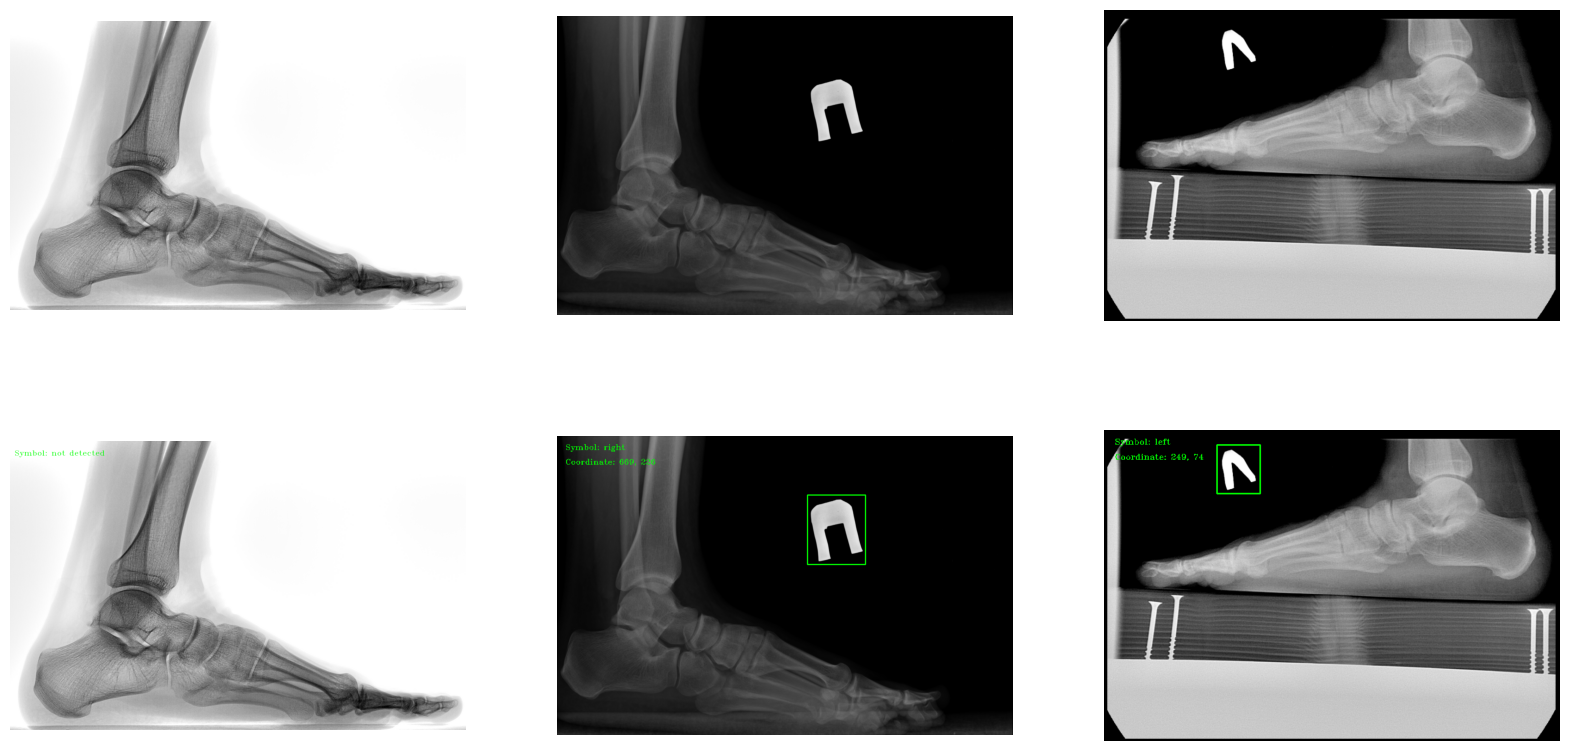

In [25]:
prediction_data = [] # для хранения информации по обнаруженному символу для каждого изображения

for result in results:
    data = dict() # для хранения информации по обнаруженым или не обнаруженым символам
    
    # для каждого изображения которое предсказывали получаем полный путь к изображению
    path_to_img = result.path
    img = cv2.imread(path_to_img)
    data['img'] = os.path.basename(path_to_img)
    print
    # Заносим в переменную обнаружен ли символ и если обнаружен то какая это нога
    left_or_right = 'not detected'
    if len(result.boxes.cls.tolist()) > 0:
        if result.boxes.cls.tolist()[0] == 0:
            left_or_right = 'left'
        else:
            left_or_right = 'right'
            
    data['left_or_right'] = left_or_right
    
    if left_or_right != 'not detected':
        # Извлекаем координаты боундингбокса для дальнейшей отрисовки на изображении
        xyxy = result.boxes.xyxy.tolist()[0]
        x1 = int(xyxy[0])
        y1 = int(xyxy[1])
        x2 = int(xyxy[2])
        y2 = int(xyxy[3])
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
        # Извлекаем координаты центра прямоуголника и наносим информацию на изображение
        x0 = int((x1 + x2) / 2)
        y0 = int((y1 + y2) / 2)

        data['x_center'] = x0
        data['y_center'] = y0
    else:
        data['x_center'] = None
        data['y_center'] = None
    
    # Наносим полученную информацию на изображение
    y_draw = img.shape[0] // 20
    for_draw = (20, y_draw)
    cv2.putText(img,
                f'Symbol: {left_or_right}',
                for_draw,
                cv2.FONT_HERSHEY_TRIPLEX,
                img.shape[0] / 1200,
                (0, 255, 0),
                1)
    
    if left_or_right != 'not detected':
        y_draw = img.shape[0] // 20 + y_draw
        for_draw = (20, y_draw)
        cv2.putText(img,
                    f'Coordinate: {str(x0)}, {str(y0)}',
                    for_draw,
                    cv2.FONT_HERSHEY_TRIPLEX,
                    img.shape[0] / 1200,
                    (0, 255, 0),
                    1)
    # Сохраняем размеченое изображение в папку
    cv2.imwrite(filename=PATH_TO_PREDICT_IMG + data['img'],
                img=img)

    prediction_data.append(data)

# Вывод информации
pprint.pprint(prediction_data)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
count = 0
for i in os.listdir(PATH_TO_IMG_FOR_PREDICT):
    axs[0][count].imshow(cv2.imread(PATH_TO_IMG_FOR_PREDICT + i))
    axs[0][count].axis('off')
    axs[1][count].imshow(cv2.imread(PATH_TO_PREDICT_IMG + i))
    axs[1][count].axis('off')
    count += 1
